# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [ ]:
!pip install torch==1.2.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/NLP/HW2

/content/drive/My Drive/NLP/HW2


In [ ]:
# Add utilities path
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [ ]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

In [ ]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [ ]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [ ]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [ ]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [ ]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
lr = 0.01;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

#### 1.1 Encoder (9 pts)

In [ ]:
import torch
import math
import time
import torch.nn as nn
from tqdm import notebook
from torch.autograd import Variable

In [ ]:
# Cite from https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x.float() + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False).float()
        return self.dropout(x)

In [ ]:
# Add transformer as encoder in seq2seq model

# with 512 embedding and hidden size, 1 layer in encoder and others. 2 heads for the transformer.

class EncoderTransformer(nn.Module):
  
  def __init__(self, vocab_size, max_len=MAX_LEN, dim=512, num_layers=1, nhead=2, dropout=0.0):
       super().__init__()
       self.token_embed = nn.Embedding(vocab_size, embedding_dim=dim)
       self.position_embed = PositionalEncoding(dim, dropout)
       encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=64, dropout=0.0)
       self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
  
  def forward(self, token_indices):
       tok_embed = self.token_embed(token_indices)
       pos = torch.arange(len(token_indices), device=token_indices.device).unsqueeze(1)
       pos_embed = self.position_embed(pos).permute(1,0,2)
       embedded = tok_embed + pos_embed
       output = self.encoder(embedded)
       #output：batch_size * seq_len * hidden layers
       #condense
       hidden_layer = torch.sum(output, dim = 1, keepdim = True).transpose(0,1).expand(1,-1,-1).contiguous()
       return output.permute(1,0,2), hidden_layer

In [ ]:
encoder = EncoderTransformer(source_vocab)
print(encoder)

EncoderTransformer(
  (token_embed): Embedding(12392, 512)
  (position_embed): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
)


#### 1.2 Decoder(s) (9 pts)

In [ ]:
# Basic RNN decoder (no attention)
basic_rnn_decoder = nnet_models_new.DecoderRNN(target_vocab, hidden_size, enc_layers)
print(basic_rnn_decoder)

DecoderRNN(
  (embedding): Embedding(20111, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax()
)


In [ ]:
# RNN Decoder with Encoder attention
decoder_encoder_attn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = True,
                                 self_attention = False)
print(decoder_encoder_attn)

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax()
  (encoder_attention_module): Attention_Module(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)


In [ ]:
# RNN Decoder with Encoder & Self attention
decoder_encoder_selfattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = True,
                                 self_attention = True)
print(decoder_encoder_selfattn)

Decoder_SelfAttn(
  (embedding): Embedding(20111, 512)
  (memory_rnn): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax()
  (projector_summ): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (encoder_attention_module): Attention_Module(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)


#### Training & Evaluation

In [ ]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [ ]:
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))

In [ ]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):

    best_bleu = -1;
    train_losses = []
    valid_bleus = []
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        train_losses += [epoch_loss]
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            val_bleus += [val_bleu_score]
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    #generate the scores for viz
    return train_losses, val_bleus


Train Model 1 --> Transformer Encoder + Basic RNN decoder (no attention)


In [ ]:
basic_model = nnet_models_new.seq2seq(encoder, basic_rnn_decoder,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
print(basic_model)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(20111, 512)
    (gru): GRU(512, 512, batch_first=True)
    (

In [ ]:
train_again = False
if os.path.exists(get_full_filepath(saved_models_dir, 'rnn')) and (not train_again):
    basic_model = torch.load(get_full_filepath(saved_models_dir, 'rnn'), map_location=global_variables.device)
else:
    train_losses_rnn, val_Bleus_rnn = train_model(dataloader_dict, basic_model, 
                                                  num_epochs = num_epochs, 
                                                  saved_model_path = saved_models_dir, 
                                                  enc_type = 'rnn_test')

Epoch: [0/20]



epoch 0 loss = 1.7301382588547682, time = 242.9058346748352
validation bleu:  2.190452233883305


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/20]



epoch 1 loss = 1.6040393194003117, time = 241.6128866672516
validation bleu:  1.4820877766172362
Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [2/20]



epoch 2 loss = 1.5405395053760498, time = 242.0321900844574
validation bleu:  1.7585235660854657
Epoch     3: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [3/20]



epoch 3 loss = 1.5268894230229704, time = 243.36144065856934
validation bleu:  1.775522779276249
Epoch: [4/20]



epoch 4 loss = 1.524522041316838, time = 231.85599780082703
validation bleu:  1.7079932821918715
Epoch: [5/20]



epoch 5 loss = 1.522077084875503, time = 227.32349729537964
validation bleu:  1.7732618276127217
Epoch: [6/20]



epoch 6 loss = 1.5187491833668336, time = 225.1960735321045
validation bleu:  1.7451894704425766
Epoch: [7/20]



epoch 7 loss = 1.5262008701995469, time = 226.05698227882385
validation bleu:  1.7542332787180466
Epoch: [8/20]



epoch 8 loss = 1.5228319153230936, time = 225.19125747680664
validation bleu:  1.7829257372261613
Epoch: [9/20]



epoch 9 loss = 1.517775883965215, time = 225.68677353858948
validation bleu:  1.7823542930071508
Epoch: [10/20]



epoch 10 loss = 1.5172036131002897, time = 225.56042313575745
validation bleu:  1.8061900823412074
Epoch: [11/20]



epoch 11 loss = 1.5168209292882038, time = 227.06705617904663
validation bleu:  1.7855216991628298
Epoch: [12/20]



epoch 12 loss = 1.5208183400848896, time = 225.59088468551636
validation bleu:  1.7531120021312907
Epoch: [13/20]



epoch 13 loss = 1.5125013037401553, time = 224.59316158294678
validation bleu:  1.7386051513413197
Epoch: [14/20]



epoch 14 loss = 1.5167462953900366, time = 224.36555528640747
validation bleu:  1.8689799981323156
Epoch: [15/20]



epoch 15 loss = 1.5154422690003202, time = 222.9638500213623
validation bleu:  1.7480982330628148
Epoch: [16/20]



epoch 16 loss = 1.5104526497650674, time = 223.01487278938293
validation bleu:  1.734724535296072
Epoch: [17/20]



epoch 17 loss = 1.5134620330340314, time = 223.34370756149292
validation bleu:  1.7527062834846063
Epoch: [18/20]



epoch 18 loss = 1.5085009421007785, time = 223.22702860832214
validation bleu:  1.774677419987838
Epoch: [19/20]



epoch 19 loss = 1.5084839724437682, time = 223.98324275016785
validation bleu:  1.817522483020243
Training completed. Best BLEU is 2.190452233883305


In [ ]:
print(basic_model.get_bleu_score(dataloader_dict['val']))

1.8215117194585357



Train Model 2 --> Transformer Encoder + RNN Decoder with Encoder attention


In [ ]:
# model 2
model_encoder_attn = nnet_models_new.seq2seq(encoder, decoder_encoder_attn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang = dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)
print(model_encoder_attn)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512)
    (

In [ ]:
# train
train_again = False
modelname = 'encoderattn'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    model_encoder_attn = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_losses_enc_att, val_BLEUs_enc_att = train_model(dataloader_dict, model_encoder_attn, 
                                                          num_epochs = num_epochs, 
                                                          saved_model_path = saved_models_dir, 
                                                          enc_type = 'encoderattn_test')

Epoch: [0/20]



epoch 0 loss = 2.3884878107715513, time = 423.17324900627136
validation bleu:  3.0898213201837152


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/20]



epoch 1 loss = 1.7672134944936906, time = 421.63281202316284
validation bleu:  5.279076166624741
Epoch: [2/20]



epoch 2 loss = 1.5968560544737818, time = 419.799378156662
validation bleu:  6.60348713233039
Epoch: [3/20]



epoch 3 loss = 1.4935113558808852, time = 418.65895676612854
validation bleu:  8.37815793527713
Epoch: [4/20]



epoch 4 loss = 1.4141624641880766, time = 423.034291267395
validation bleu:  8.977013754837206
Epoch: [5/20]



epoch 5 loss = 1.3449719036715182, time = 419.7384126186371
validation bleu:  10.22933411947771
Epoch: [6/20]



epoch 6 loss = 1.2927204400548644, time = 417.2053611278534
validation bleu:  10.443416156454798
Epoch: [7/20]



epoch 7 loss = 1.2473929939507777, time = 414.87885761260986
validation bleu:  11.548842473081018
Epoch: [8/20]



epoch 8 loss = 1.1993352728207025, time = 419.09781312942505
validation bleu:  12.725740236760727
Epoch: [9/20]



epoch 9 loss = 1.1666672516397492, time = 417.53962564468384
validation bleu:  12.94114091596671
Epoch: [10/20]



epoch 10 loss = 1.1329394255978908, time = 418.24709391593933
validation bleu:  13.767159266958194
Epoch: [11/20]



epoch 11 loss = 1.1044127397920287, time = 417.54901123046875
validation bleu:  14.226957101038527
Epoch: [12/20]



epoch 12 loss = 1.0745876581054645, time = 417.0213077068329
validation bleu:  14.59641020854716
Epoch: [13/20]



epoch 13 loss = 1.055747454615511, time = 414.5595769882202
validation bleu:  15.339267717435625
Epoch: [14/20]



epoch 14 loss = 1.0313071087787027, time = 414.6198606491089
validation bleu:  15.25795405298727
Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [15/20]



epoch 15 loss = 0.9717366274704233, time = 418.1156907081604
validation bleu:  17.103989385018465
Epoch: [16/20]



epoch 16 loss = 0.9446158266133549, time = 416.5545756816864
validation bleu:  17.538560566477877
Epoch: [17/20]



epoch 17 loss = 0.9340293480088506, time = 413.9114615917206
validation bleu:  17.427948814932947
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [18/20]



epoch 18 loss = 0.9229517376323816, time = 419.2245900630951
validation bleu:  17.830776738805405
Epoch: [19/20]



epoch 19 loss = 0.9187160781711092, time = 417.934006690979
validation bleu:  17.715736354097338
Training completed. Best BLEU is 17.830776738805405


Train Model 3 --> Transformer Encoder + RNN Decoder with Encoder & Self attention

In [ ]:
# model 3
model_encoder_selfattn = nnet_models_new.seq2seq(encoder, decoder_encoder_selfattn,
                                  lr = lr, 
                                  use_cuda = use_cuda, 
                                  hiddensize = hidden_size, 
                                  numlayers = hidden_size, 
                                  target_lang=dataset_dict['train'].target_lang_obj,
                                  longest_label = longest_label,
                                  clip = gradient_clip)
print(model_encoder_selfattn)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512)
    (

In [ ]:
# Train
train_again = False
modelname = 'encoderselfattn'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_encoder_selfattn = torch.load(get_full_filepath(saved_models_dir, modelname), map_location=global_variables.device)
else:
    train_losses_enc_selfatt, val_BLEUs_enc_selfatt = train_model(dataloader_dict, model_encoder_selfattn, 
                                                                  num_epochs = num_epochs, 
                                                                  saved_model_path = saved_models_dir, 
                                                                  enc_type = modelname)


Epoch: [0/20]



epoch 0 loss = 2.2942834241898766, time = 458.46828293800354
validation bleu:  5.266138157652963


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/20]


KeyboardInterrupt: ignored

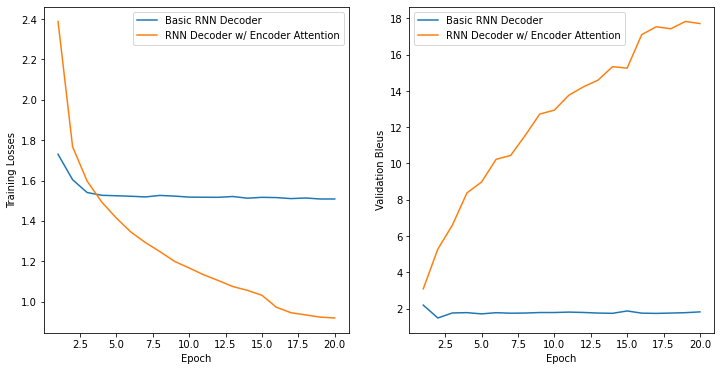

In [ ]:
# VIZ:Training & validation curves for both loss and BLEU
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(np.arange(1,21), train_losses_rnn, label = "Basic RNN Decoder")
plt.plot(np.arange(1,21), train_losses_enc_att, label = "RNN Decoder w/ Encoder Attention")
#plt.plot(np.arange(1,21), train_losses_enc_selfatt, label = "RNN Decoder w/ Encoder & Self Attention")
plt.xlabel("Epoch")
plt.ylabel("Training Losses")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,21), val_Bleus_rnn, label = "Basic RNN Decoder")
plt.plot(np.arange(1,21), val_BLEUs_enc_att, label = "RNN Decoder w/ Encoder Attention")
#plt.plot(np.arange(1,21), val_BLEUs_enc_selfatt, label = "RNN Decoder w/ Encoder & Self Attention")
plt.xlabel("Epoch")
plt.ylabel("Validation Bleus")
plt.legend()
plt.show()
# only two models

---
### 2 Attention visualization (12 pts)

In [ ]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [ ]:
!pip install googletrans

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 972kB 6.8MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=1640d67a1007f071da6ce5d3b871be01f37753b0f7bb16efef9aec36c88bc57f
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=b9ee86203b85dbb22f49f474011312f5b1274120e0c76ce5c5c5267f9e89f54d
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
#     source_len = np.sort(np.array(val_dataset.main_df['source_len']))
#     len_threshold = [0]+[source_len[x*1000+376] for x in range(1, 21)];
#     len_threshold = np.unique(len_threshold)
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
#         min_len = 0
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('GT on sentence (src->tgt): ', translator.translate(sentence, 
                                                     src = source_name,
                                                     dest = target_name).text)
    print('GT on prediction (tgt->src): ', translator.translate(prediction, 
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

Model 2 visualization

souce:  hello how are you ?
prediction:  combien de temps etes vous en train de dire combien je vous ai ?
GT on sentence (src->tgt):  salut comment allez-vous ?
GT on prediction (tgt->src):  how long are you saying how much I have you?


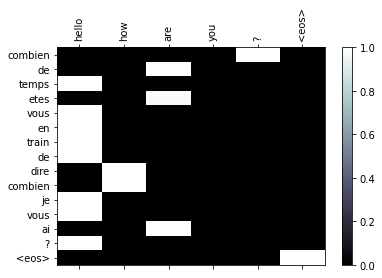

In [ ]:
get_translation(model_encoder_attn, 'hello how are you ?', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle sait mieux avec lui a son egard avec lui .
GT on sentence (src->tgt):  elle sait mieux que de discuter avec lui.
GT on prediction (tgt->src):  she knows best with him about her with him.


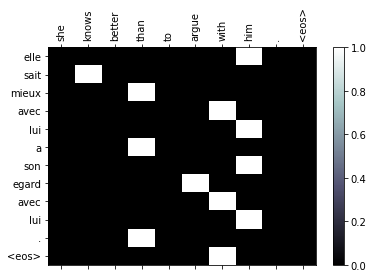

In [ ]:
get_translation(model_encoder_attn, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she s five years years than me .
prediction:  elle m a conseille de faire mieux ans .
GT on sentence (src->tgt):  elle a cinq ans que moi.
GT on prediction (tgt->src):  she advised me to do better years ago.


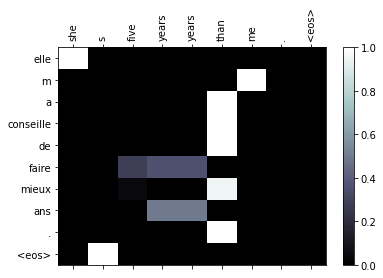

In [ ]:
get_translation(model_encoder_attn, 'she s five years years than me .', source_lang_obj, use_cuda)

Model 3 visualization

souce:  hello how are you ?
prediction:  latitude
GT on sentence (src->tgt):  salut comment allez-vous ?
GT on prediction (tgt->src):  latitude


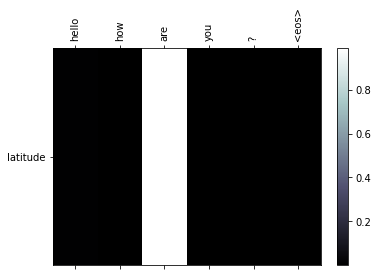

In [ ]:
get_translation(model_encoder_selfattn, 'hello how are you ?', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  domicile
GT on sentence (src->tgt):  elle sait mieux que de discuter avec lui.
GT on prediction (tgt->src):  home


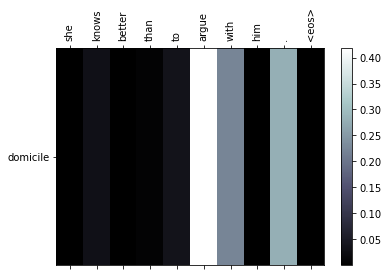

In [ ]:
get_translation(model_encoder_selfattn, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she s five years years than me .
prediction:  enflammai
GT on sentence (src->tgt):  elle a cinq ans que moi.
GT on prediction (tgt->src):  ignited


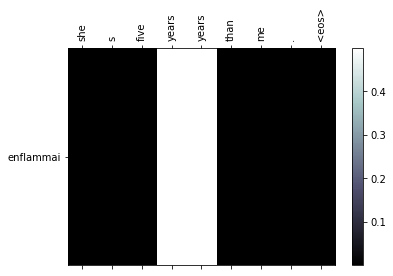

In [ ]:
get_translation(model_encoder_selfattn, 'she s five years years than me .', source_lang_obj, use_cuda)